In [1]:
from scipy.io import loadmat
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
from sklearn.svm import SVC
%matplotlib inline

In [2]:
_,_,_,X_trn_data1, X_tst_data1, Y_trn_data1, Y_tst_data1 = loadmat('data/data1.mat').values()
_,_,_,X_trn_data2, X_tst_data2, Y_trn_data2, Y_tst_data2 = loadmat('data/data2.mat').values()

## Logistic Function Classifier

In [3]:
#Logistic Regression
class LogisticRegression():
    '''
    Implementation of the logistic regression classifier algorithm. Minimizes the loss function using via gradient descent.
    By default uses regularization.
    '''
    def __init__(self):
        return None
    
    def train(self,X,Y,eta,m,lambda_):
        '''
        Training function. 
        Trains the classifier via gradient descent. Depending on m it can stochastic, mini-batch or gradient descent.
        '''
        X_copy = np.copy(X) #create a copy of the data
        X_copy = np.array([np.append(x,[1]) for x in X_copy])
        for i in range(len(X_copy[0])):
            #for all col i in X get the mean and standard deviation
            col=np.array([[X_copy[j][i]] for j in range(len(X_copy))])
            col_mean=np.mean(col) 
            col_std = np.std(col)
            for j in range(len(X_copy)):
                if col_std!=0:
                    X_copy[j][i]=(X_copy[j][i]-col_mean)/col_std #scale data to prevent theta overflow
        
        epsilon = 10**-3 #arbitarily chosen small number e << 1
        theta = np.array(np.array([np.array([float(0)])]*len(X_copy[0]))) #hard start at zero vector
        gradient = np.array(np.array([np.array([10])]*len(X_copy[0]))) #large gradient initialized so that while loop will always start
        while np.sum(gradient)>=epsilon: #until gradient < epsilon
            m_indices = random.sample(range(len(X_copy)),m)
            gradient = np.reshape(np.array(eta*np.sum(np.array([X_copy[i]*(Y[i]-(1/(1+np.exp(np.dot(-theta.T,X_copy[i]))))) - lambda_*2*np.sum(theta) for i in m_indices]),axis=0)),newshape=(3,1))
            theta += gradient
        return theta

    def test(self,X,theta):
        '''
        Testing function. Takes the vector theta and computes dot product of theta and test set.
        The resulting vector is a probability vector where if the values are greater than 0 its 1 and if its less than 0 its -1.
        Using that knowledge we output a prediction vector of 1s and 0s.
        '''
        X_copy = np.copy(X) #create a copy of the data
        X_copy = np.array([np.append(x,[1]) for x in X_copy])
        for i in range(len(X_copy[0])):
            #for all col i in X get the mean and standard deviation
            col=np.array([[X_copy[j][i]] for j in range(len(X_copy))])
            col_mean=np.mean(col) 
            col_std = np.std(col)
            for j in range(len(X_copy)):
                if col_std!=0:
                    X_copy[j][i]=(X_copy[j][i]-col_mean)/col_std #scale data to prevent theta overflow
                else:
                    X_copy[j][i]-(X_copy[j][i]-col_mean)
        y_prob = np.dot(X_copy,theta)
        y_pred = np.array([[1 if p>0 else 0 for p in x] for x in y_prob])
        return y_pred

## Functions

In [19]:
#classification error
def classificationError(y_pred,y_true):
    '''
    number wrong/total number of samples'''
    wrong = 0
    total = len(y_true)
    for i in range(len(y_pred)):
        if y_pred[i]!=y_true[i]:
            wrong+=1
    return wrong/total 

#grid search for logit
def gridSearchLogit(X_trn, Y_trn, X_tst, Y_tst,params):
    '''
    Conducts a grid search of all important parameters. Parameters is a dictionary.
    '''
    combinations = list(itertools.product(list(params.values())[0],list(params.values())[1]))
    error = 1000
    for comb in combinations: #train and test model using all combinations of hyperparameters
        model = LogisticRegression()
        theta = model.train(X_trn,Y_trn,comb[0],1,comb[1])
        y_pred = model.test(X_tst,theta)
        temp = classificationError(y_pred,Y_tst)
        if error>= temp: #if the current error is better than previous error update best hyperparameters
            error = temp
            best_lambda = comb[1]
            best_eta = comb[0]
    return best_eta, best_lambda


#K Fold Cross-Validation for logit
def kFoldCVLogit(k,X,Y):
    '''
    Function that allows for k-fold cross validation. K-fold cross validation a way to a train a classifier by 
    making k partitions of the data. Then it takes these k partitions and then for each partition, it makes that
    a hold-out set and the rest of the data a training set. It takes the best parameters based on each partition via
    a grid search and then gets the average of the hyperparameters.
    '''
    random.seed(141)
    
    #shuffle both X and Y
    indices = list(range(len(X)))
    random.shuffle(indices)
    X_copy=np.copy(X)[indices]
    Y_copy=np.copy(Y)[indices]
    
    lenPartitions = len(X_copy)//k #the size of each partition
    best_params = []
    for part in range(k):
        start = part*lenPartitions
        end = (part+1)*lenPartitions
        holdOutIndices = list(range(start,end)) #define hold out set as set from set start to end index
        restIndices = list(set(range(len(X_copy))).difference(set(holdOutIndices))) #anything not in the hold out set defined here
        
        #create hold out set and training set
        X_train = X_copy[restIndices]
        Y_train = Y_copy[restIndices]
        X_test = X_copy[holdOutIndices]
        Y_test = Y_copy[holdOutIndices]
        
        #update best params so that we can average of both hyperparameters
        best_params.append(gridSearchLogit(X_train,Y_train,X_test,Y_test,{'learning_rate':[0.01,0.02,0.03],'lambda':[.1,.2,.3]}))
    avgEta = np.mean([x[0] for x in best_params])
    avgLambda = np.mean([x[1] for x in best_params])
    return avgEta, avgLambda


#decision boundary
def decisionBounary(X,theta):
    '''
    Plots decision boundary of classifier.
    '''
    plt.figure()
    X_copy = np.copy(X) #create a copy of the data
    X_copy = np.array([np.append(x,[1]) for x in X_copy])
    for i in range(len(X_copy[0])):
        #for all col i in X get the mean and standard deviation
        col=np.array([[X_copy[j][i]] for j in range(len(X_copy))])
        col_mean=np.mean(col) 
        col_std = np.std(col)
        for j in range(len(X_copy)):
            if col_std!=0:
                X_copy[j][i]=(X_copy[j][i]-col_mean)/col_std #scale data to prevent theta overflow
    
    #defines classes
    class_ = np.array([[1 if p>0 else 0 for p in x] for x in np.dot(X_copy,theta)])
    class_ = [x[0] for x in class_]
    
    #if it belongs in in group one, its x and y goes in one group
    xAxis1 = [X_copy[i][0] for i in range(len(X_copy)) if class_[i]==1]
    yAxis1 = [X_copy[i][1] for i in range(len(X_copy)) if class_[i]==1]
    xAxis0 = [X_copy[i][0] for i in range(len(X_copy)) if class_[i]==0]
    yAxis0 = [X_copy[i][1] for i in range(len(X_copy)) if class_[i]==0]
    
    #create hyperplane wTx
    x=np.linspace(-2,2)
    y= -(theta[0]/theta[1])*x + (theta[2]/theta[1])
    plt.scatter(xAxis1,yAxis1, marker='*')
    plt.scatter(xAxis0,yAxis0,marker='+')
    plt.plot(x,y,'k-')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('Decision Boundary for Logistic Regression')

## Dataset 1 Logistic Regression

In [7]:
eta,lambda_ = kFoldCVLogit(3,X_trn_data1,Y_trn_data1)
model = LogisticRegression()
theta = model.train(X_trn_data1,Y_trn_data1,eta,1,lambda_)
print(f'w: {theta}')

w: [[ 0.05298225]
 [-0.05044266]
 [ 0.014333  ]]


### Training Set

Classification Error:  0.0


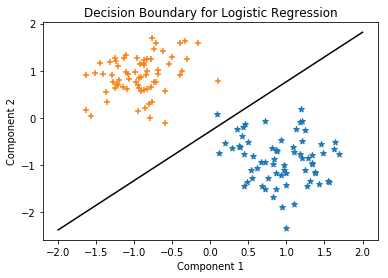

In [8]:
y_pred_trn = model.test(X_trn_data1,theta)
print('Classification Error: ', classificationError(y_pred_trn,Y_trn_data1))
decisionBounary(X_trn_data1,theta)

### Testing Set

Classification Error:  0.0


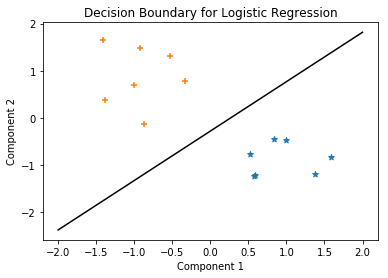

In [9]:
y_pred = model.test(X_tst_data1,theta)
print('Classification Error: ', classificationError(y_pred,Y_tst_data1))
decisionBounary(X_tst_data1,theta)

## Dataset 2 Logistic Regression

In [10]:
eta,lambda_ = kFoldCVLogit(3,X_trn_data2,Y_trn_data2)
model = LogisticRegression()
theta = model.train(X_trn_data2,Y_trn_data2,eta,1,lambda_)
print(f'w: {theta}')

w: [[ 0.06918188]
 [-0.03275736]
 [-0.02625087]]


### Training Set

Classification Error:  0.05555555555555555


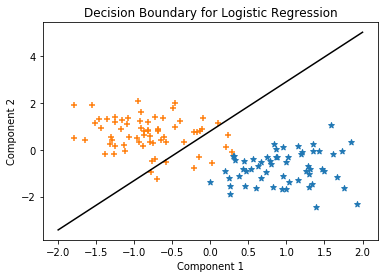

In [11]:
y_pred_trn = model.test(X_trn_data2,theta)
print('Classification Error: ', classificationError(y_pred_trn,Y_trn_data2))
decisionBounary(X_trn_data2,theta)

### Testing Set

Classification Error:  0.07142857142857142


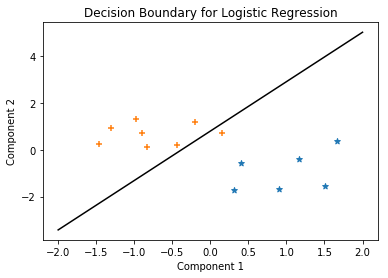

In [12]:
y_pred = model.test(X_tst_data2,theta)
print('Classification Error: ', classificationError(y_pred,Y_tst_data2))
decisionBounary(X_tst_data2,theta)

Between part A and part B we find that there is a misclassified datapoint in part B. We know this because our classification error is greater than 0. If you look at how the data is separated in part A, the training set is nearly perfectly separated the test set was well within those decision boundaries. In part B, we don't have that occuring, where we misclassified 5.5% of the data points. So it's not surprising when points were misclassified in the testing set. 